In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import sys
sys.path.append('..')

from lib.utils import get_color, print_censored_rate, transform_data

SEED = 42
np.random.seed(SEED)

In [2]:
data = pd.read_csv('../files/data/churn-data-fit.csv')

df = transform_data(data)

clear_output(wait=True)
print_censored_rate(df)
df

Total Customers: 11.637 | Censored: 2.381 | Non-censored: 9.256 | Censored Rate 20,46%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,months,failed_ratio,usage_diff,momentum
0,5142ef7b2169540c17000001,1,2015-03-01,0.0,1.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5142ef7b2169540c17000001,1,2015-04-01,1.0,0.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-2.2
2,51643b584bcdb1cc6800001e,2,2015-01-01,0.0,26.0,2015-01-01,2017-03-01,1,9.26,9.26,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51643b584bcdb1cc6800001e,2,2015-02-01,1.0,25.0,2015-01-01,2017-03-01,1,9.26,18.52,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
4,51643b584bcdb1cc6800001e,2,2015-03-01,2.0,24.0,2015-01-01,2017-03-01,1,8.26,117.69,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215641,66103d1c508579d0d5fc9727,11633,2024-03-01,0.0,1.0,2024-03-01,2024-04-01,1,52.79,52.79,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215642,66105263508579d0d5fca27d,11634,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,72.75,72.75,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215643,661063c1508579d0d5fcae2c,11635,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,41.97,41.97,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215644,66106e13423bb304f227d752,11636,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,32.15,32.15,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


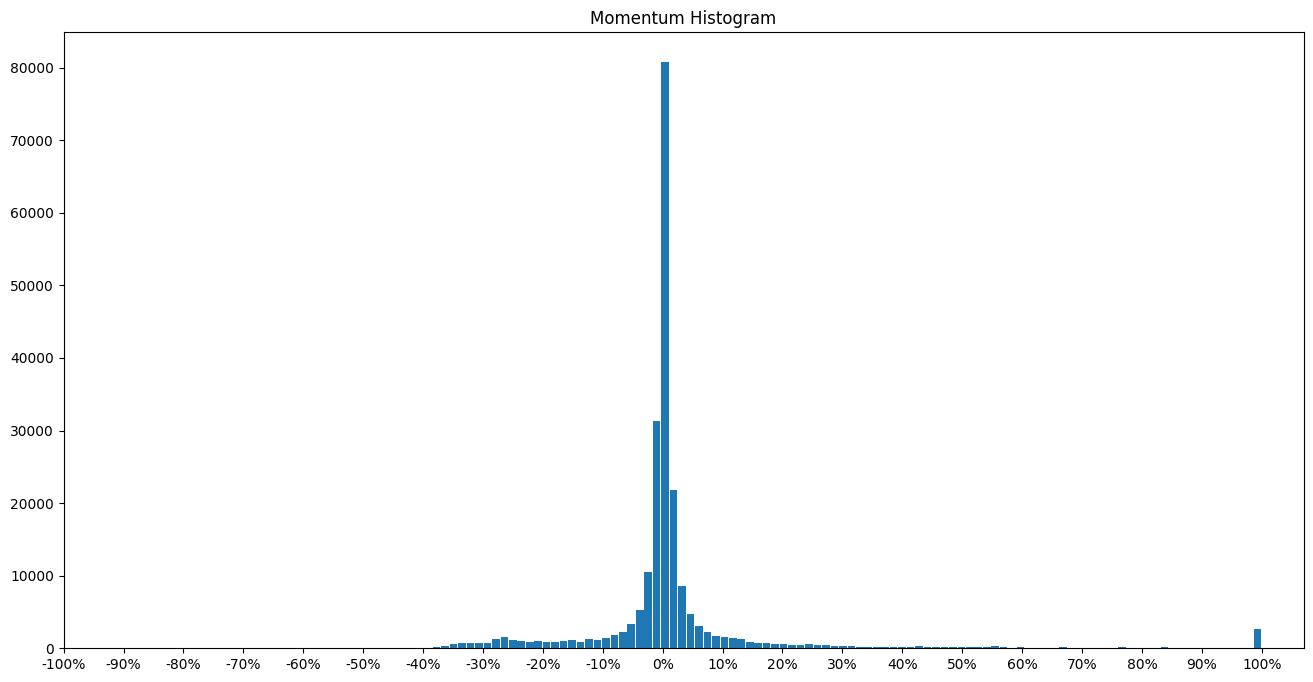

In [3]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(
    df['momentum'], bins=100, color=get_color('blue'), rwidth=0.9
)

ax.set_xticks(np.arange(-100, 110, 10))
ax.set_xticklabels([f'{i}%' for i in ax.get_xticks()])

ax.set_title('Momentum Histogram')

plt.show()

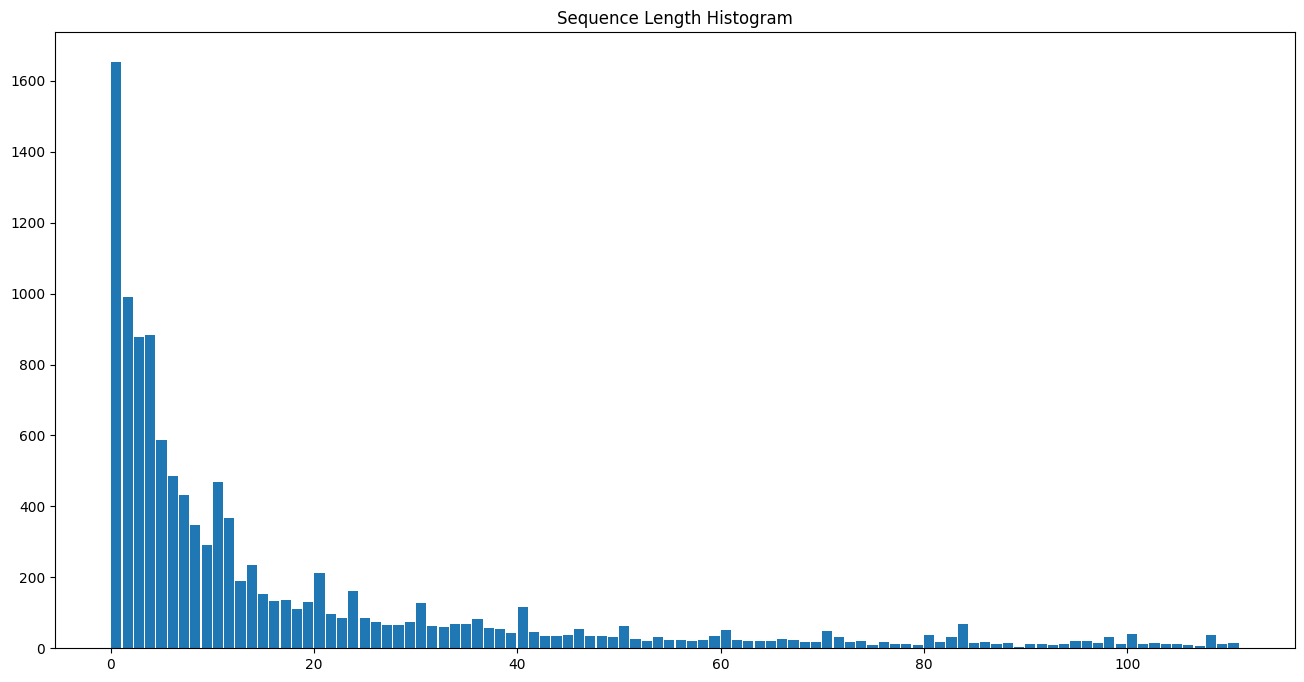

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(
    df.groupby('id')['tfs'].max(), bins=100, color=get_color('blue'), rwidth=0.9
)

ax.set_title('Sequence Length Histogram')

plt.show()

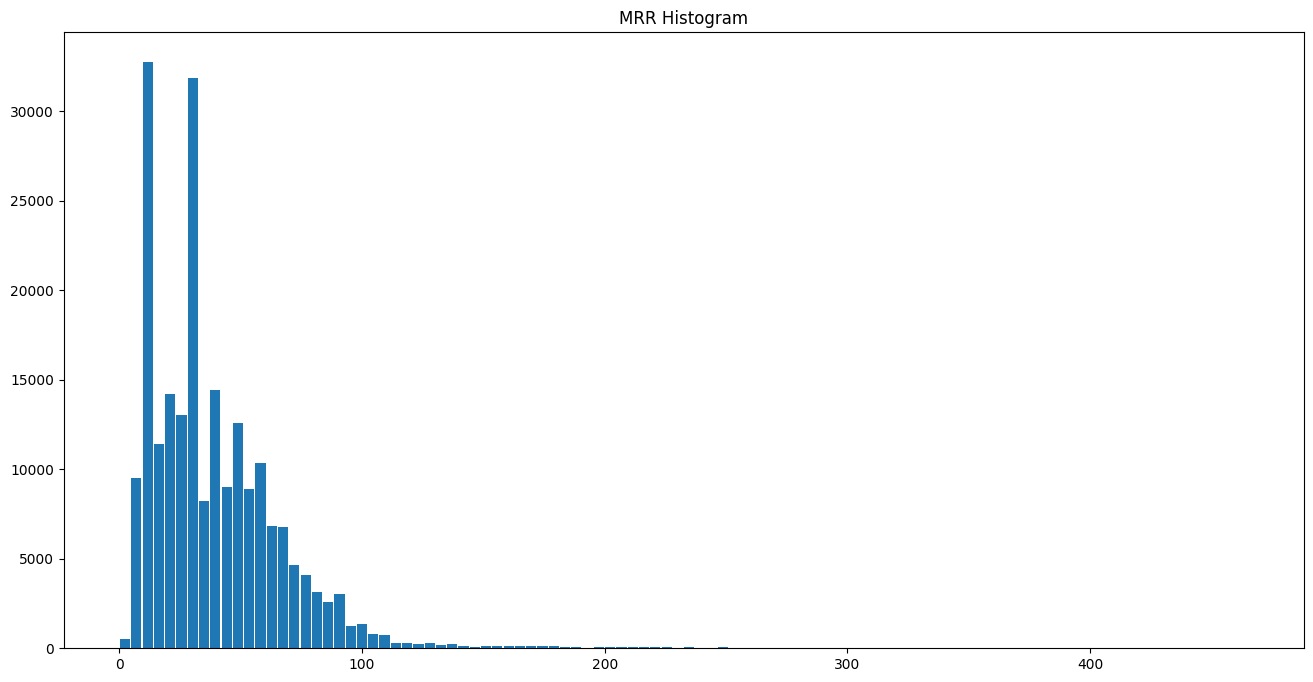

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(
    df['mrr'], bins=100, color=get_color('blue'), rwidth=0.9
)

ax.set_title('MRR Histogram')

plt.show()

In [6]:
n_samples = 6
min_periods = 6

dg = df.groupby('id')['active'].sum()
ids = shuffle(
    dg[dg > min_periods].index.tolist(),
    random_state=SEED
)[:n_samples]

print(ids)

[2995, 4735, 7640, 1457, 5615, 103]


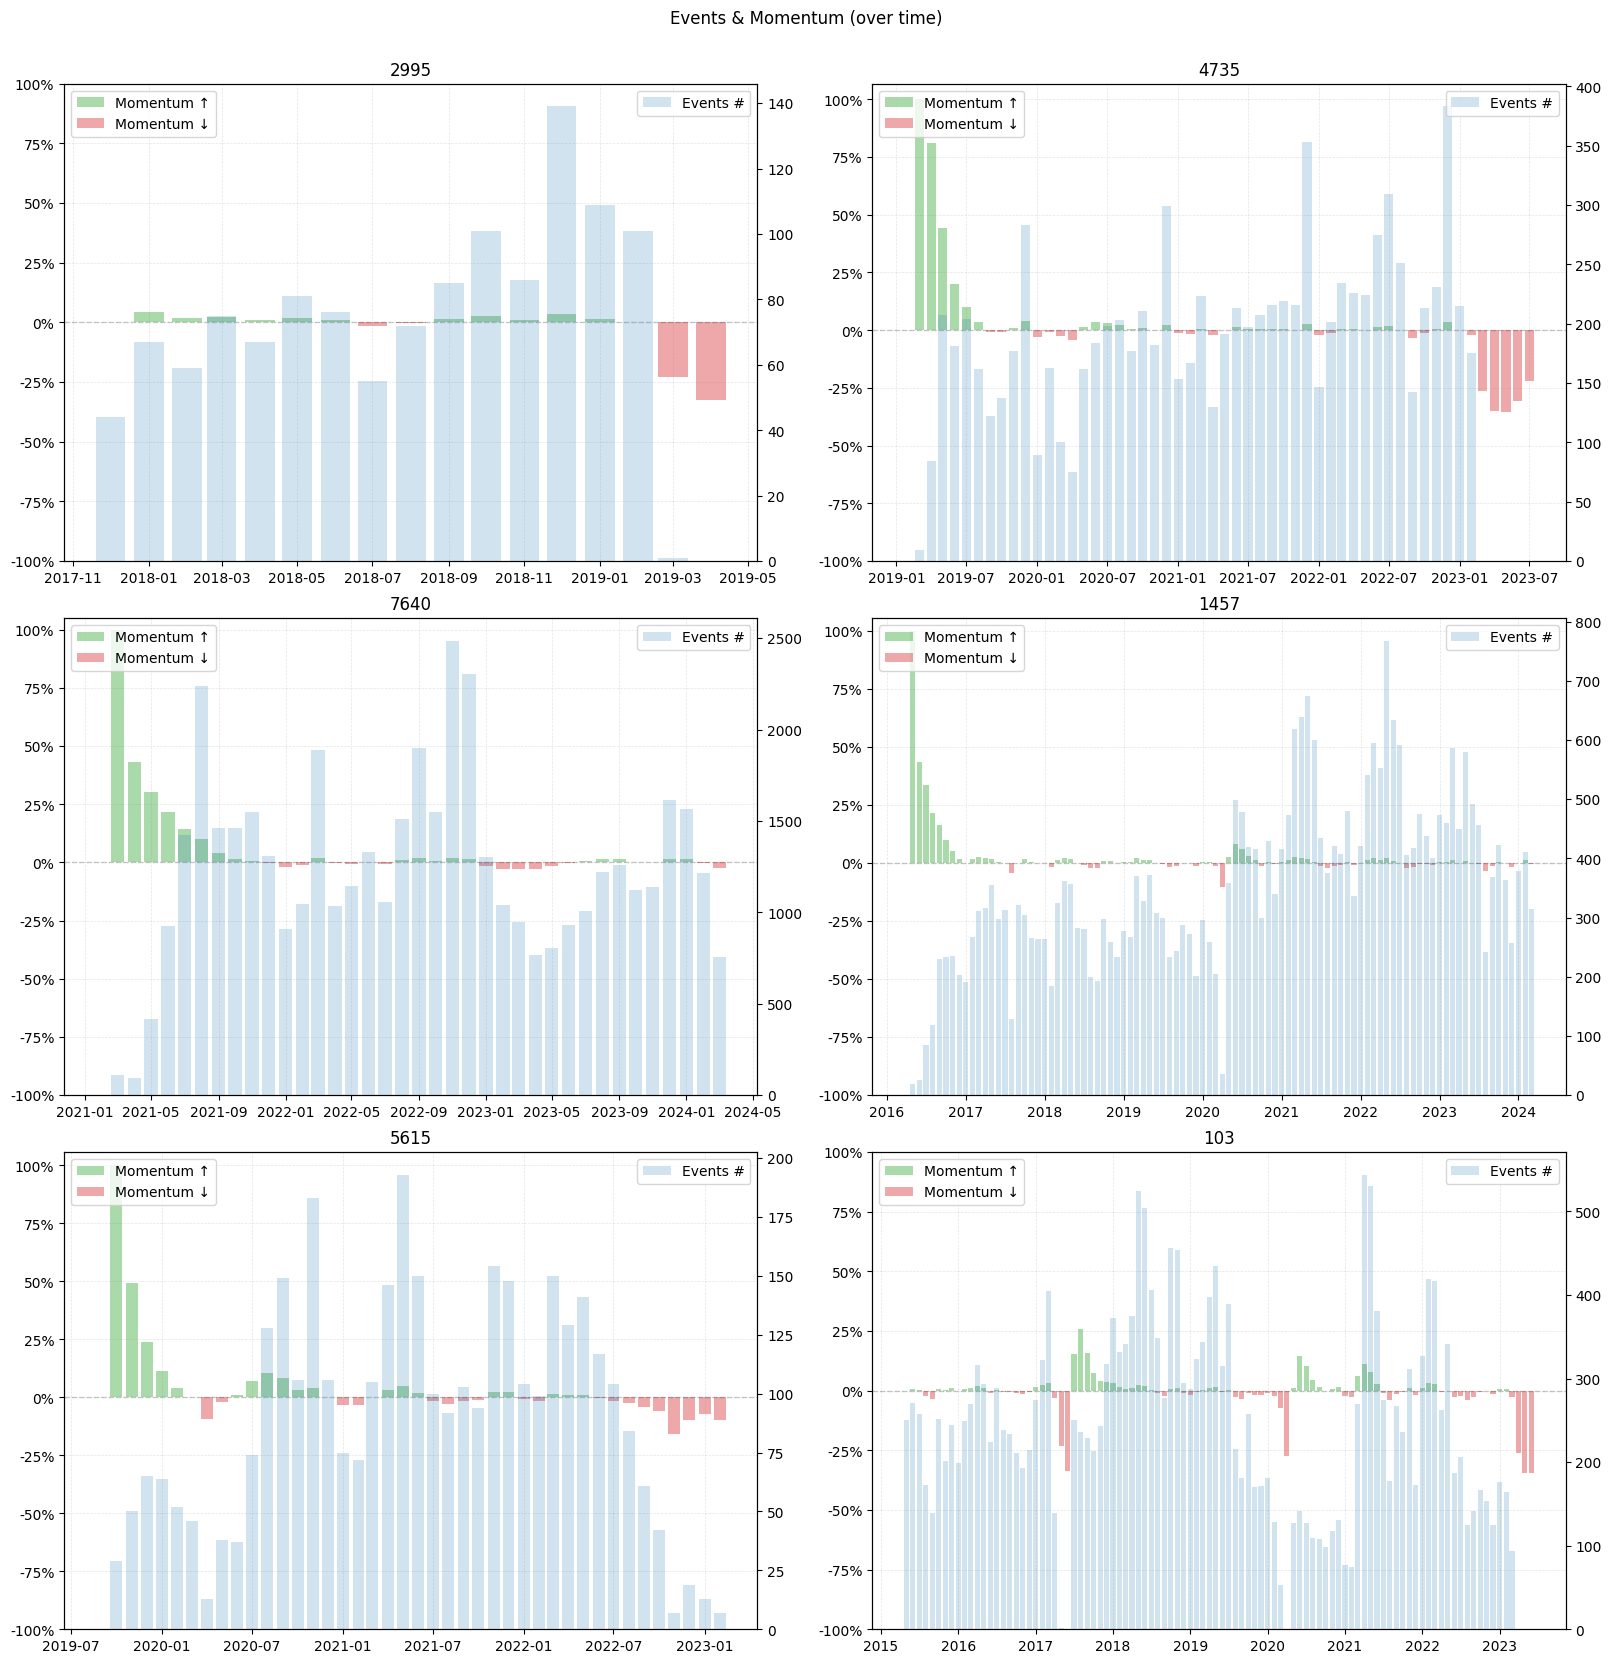

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), constrained_layout=True)
axs = axs.flatten()

for i, uid in enumerate(ids):
    d_ = df[df['id'] == uid].set_index('tp')[['momentum', 'events']]
    d_['mom_pos'] = [i if i > 0 else np.NaN for i in d_['momentum']]
    d_['mom_neg'] = [i if i < 0 else np.NaN for i in d_['momentum']]
    d_ = d_.drop(columns=['momentum'])[['mom_pos', 'mom_neg', 'events']]

    ax = axs[i]
    ax2 = ax.twinx()

    ax.bar(
        d_.index, d_['mom_pos'], width=24, color=get_color('green'), alpha=0.4, label='Momentum ↑'
    )
    ax.bar(
        d_.index, d_['mom_neg'], width=24, color=get_color('red'), alpha=0.4, label='Momentum ↓'
    )
    ax2.bar(
        d_.index, d_['events'], width=24, color=get_color('blue'), alpha=0.2, label='Events #'
    )

    ax.axhline(0, color='k', ls='--', lw=1, alpha=0.2)

    ax.set_yticks([-100, -75, -50, -25, 0, 25, 50, 75, 100])
    ax.set_yticklabels([f'{i}%' for i in ax.get_yticks()])

    ax.grid(True, ls='--', lw=.5, color=get_color('grey'), alpha=0.2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax.set_title(uid)

plt.suptitle('Events & Momentum (over time)', y=1.03)

plt.show()